### Stroke Prediction Data Science Career Track final project by Albert Cort Banke
_____________________________________________________________________________________________________________________________________________

Project scope

***Goal***: To draw insights from the stroke dataset and illustrate interesting features by answering questions with visualizations and summary statistics as well as using ML to predict strokes

***Data***: There is one dataset. The data is about health of patients occuring strokes and the features associated with incurring a stroke 

***Analysis***: The project composes an exploratory data analysis and hypothesis testing to assess the data and determine associations in the data. Following this, the usage of supervised machine learning models helps predict what features are important to determine strokes

***Questions***: What models has the best classification rate? What is the most telling feature of a stroke? 

_____________________________________________________________________________________________________________________________________________

**1. Preparation**

Import the relevant libraries (A) and import and read the data (B)

In [357]:
# (A)
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [358]:
# (B)
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Print the first few observations to check the data has been imported correctly

print(stroke.head())

# The datasets look correct at first glance. There are som blank values seen from line 1 in the bmi column, which has a NaN message.
# An overview of the variables included in the dataset is below. Columns datatypes is attached to each attribute
# 1) id: unique identifier - continuous integer
# 2) gender: "Male", "Female" or "Other" - nominal categorical 
# 3) age: age of the patient - continuous integer
# 4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension - binary integer
# 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease - binary integer
# 6) ever_married: "No" or "Yes"- binary categorical
# 7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"- nominal categorical
# 8) Residence_type: "Rural" or "Urban" - binary categorical
# 9) avg_glucose_level: average glucose level in blood - continuous integer
# 10) bmi: body mass index - continuous integer
# 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"* - nominal categorical
# 12) stroke: 1 if the patient had a stroke or 0 if not - binary integer


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [359]:
# Check for missing values in the datasets

print(stroke.info())

# The BMI attribute has an overload of missing entries. The other columns in the species dataset appears complete

# There is a total of 5109 entries in the dataset, excluding headers

# From the info() header we see that the data almost has an event split between the object and integer datatypes 
# This means half of the data is strings or text while the other is numerical
# This is important to note beacause it affects which visualisations and statistics are wise to use 

# Let us inspect the text columns to find out whether any missing values have snuck in as texted values

text_column_values = stroke[["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]].values.ravel()
unique_values =  pd.unique(text_column_values)
print(unique_values)

# This reveals multiple alerts needing to be adressed with data transformation
# 1) An 'unknown' answer exists in the smoking_status column, which needs to be removed
# 2) Both the attribute header 'Residence_type' and values in many of the categorical columns have upper case letters. To ensure 
# better computability the transformation should lowercase all inputs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
['Male' 'Yes' 'Private' 'Urban' 'formerly smoked' 'Female' 'Self-employed'
 'Rural' 'never smoked' 'smokes' 'No' 'Unknown' 'Govt_job' 'children'
 'Never

2. Data transformation

Prepare (C) the dataset and review (D) it for the exploratory data analysis

In [360]:
# (C) Prepare the dataset by transforming unnecessary features and elements

# Streamline the columns in lowercase letters
stroke.columns = stroke.columns.str.lower()

# Streamline the values into lowercase letters if the value is a string
stroke = stroke.applymap(lambda s: s.lower() if type(s) == str else s)

# Remove blank spaces and replace with underscores
stroke = stroke.replace(' ','_', regex=True)

# Drop rows with missing values
stroke = stroke.dropna()

# Find categorical variables
cat_columns = stroke.select_dtypes(['object']).columns

#See the original unique range
print(stroke.work_type.unique())

# Convert all categorical variables to numeric
stroke[cat_columns] = stroke[cat_columns].apply(lambda x: pd.factorize(x)[0])

# Print to check all of the above has been implemented
print(stroke.head())
print(stroke.isnull().sum())
print(stroke.work_type.unique())
# Data transformation is completed and the project can move on to analyse

['private' 'self-employed' 'govt_job' 'children' 'never_worked']
      id  gender   age  hypertension  heart_disease  ever_married  work_type  \
0   9046       0  67.0             0              1             0          0   
2  31112       0  80.0             0              1             0          0   
3  60182       1  49.0             0              0             0          0   
4   1665       1  79.0             1              0             0          1   
5  56669       0  81.0             0              0             0          0   

   residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               0             228.69  36.6               0       1  
2               1             105.92  32.5               1       1  
3               0             171.23  34.4               2       1  
4               1             174.12  24.0               1       1  
5               0             186.21  29.0               0       1  
id                   0
gender           

<Figure size 720x432 with 0 Axes>

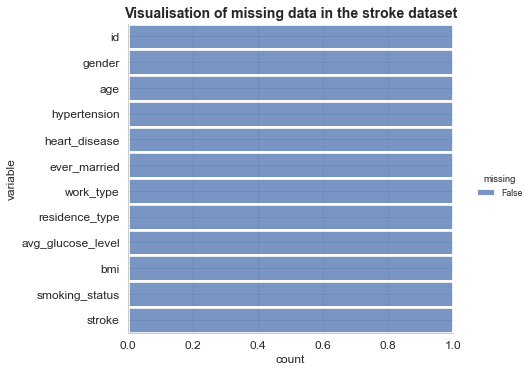

<Figure size 432x288 with 0 Axes>

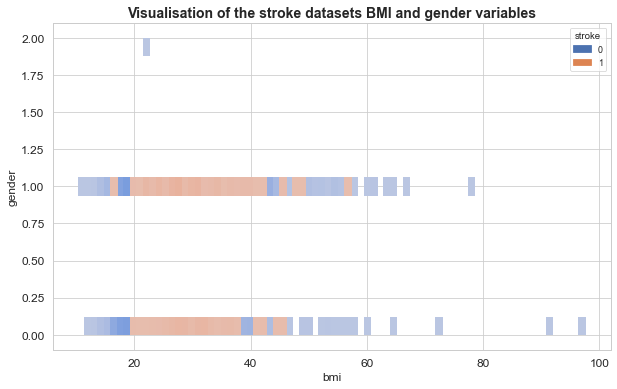

<Figure size 432x288 with 0 Axes>

In [361]:
# (D) Review the dataset by graphically looking at its vitals and testing a graph to see if the data has been transformed well

# Checking for missing data

sns.color_palette('husl')
sns.set(style = 'whitegrid', font_scale = 1.5)
sns.set_context('paper')

plt.figure(figsize=(10,6))
sns.displot(data = stroke.isna().melt(value_name="missing"),
            y='variable',
            hue = 'missing',
            multiple='fill',
            aspect=1.25
            )

plt.title('Visualisation of missing data in the stroke dataset', fontsize= 14, fontweight="bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('count', fontsize = 12)
plt.ylabel('variable', fontsize = 12)

plt.show()
plt.clf()

# The visalization showcase a complete dataset

# Making a simple histplot with Seaborn

plt.figure(figsize=(10,6))

sns.histplot(stroke, x='bmi', y = 'gender', hue = 'stroke', legend=True)

plt.title('Visualisation of the stroke datasets BMI and gender variables', fontsize= 14, fontweight="bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('bmi', fontsize = 12)
plt.ylabel('gender', fontsize = 12)

plt.show()
plt.clf()

# Looks good - the project moves on showcase the summary statistics


3. Exploratory Data Analysis

This section consists of two parts. The first is a summary (E) of the statistical aspects of the data. The second is visualization (F) module, which consists of univariate, bivariate, and multivariate analysis.  

In [362]:
# (E) Summary statistics with Pandas .describe() function

print(stroke.describe())

                 id       gender          age  hypertension  heart_disease  \
count   4909.000000  4909.000000  4909.000000   4909.000000    4909.000000   
mean   37064.313506     0.590548    42.865374      0.091872       0.049501   
std    20995.098457     0.492197    22.555115      0.288875       0.216934   
min       77.000000     0.000000     0.080000      0.000000       0.000000   
25%    18605.000000     0.000000    25.000000      0.000000       0.000000   
50%    37608.000000     1.000000    44.000000      0.000000       0.000000   
75%    55220.000000     1.000000    60.000000      0.000000       0.000000   
max    72940.000000     2.000000    82.000000      1.000000       1.000000   

       ever_married    work_type  residence_type  avg_glucose_level  \
count   4909.000000  4909.000000     4909.000000        4909.000000   
mean       0.347321     0.842534        0.492768         105.305150   
std        0.476167     1.124057        0.499999          44.424341   
min        0.

Interpretation of the statistics

First one should notice that the code only present us with the quantitative variables. 

***Count:*** The specified amount of data in our dataset is now 4909 instances. The transformation excluded all the missing rows, thus a reduction in the sum. This change is a loss of under 5% of the total sum of data, and the project accepts this as a loss not too large to compromise the quality of the dataset.

***Age:*** The mean age is 42.86 years, the youngest age is 0.08 years while the eldest age is 82. This indicates that the dataset is representative of different age groups and not biased towards elder people for example.

***Avg_glucose_level:*** The average glucose level is 105, which is the average of the of all the patients average. The std. deviation is 44, a rather high value and the min/max values of 55 and 271 indicates a high difference in values. This should be analyzed visually as well.

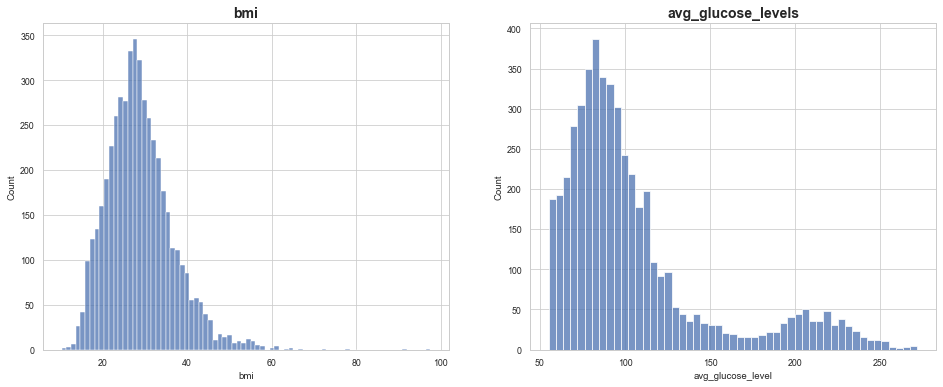

<Figure size 432x288 with 0 Axes>

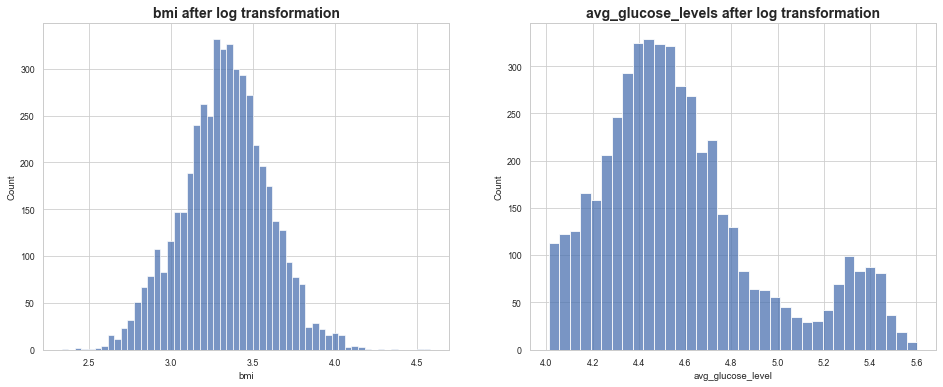

<Figure size 432x288 with 0 Axes>

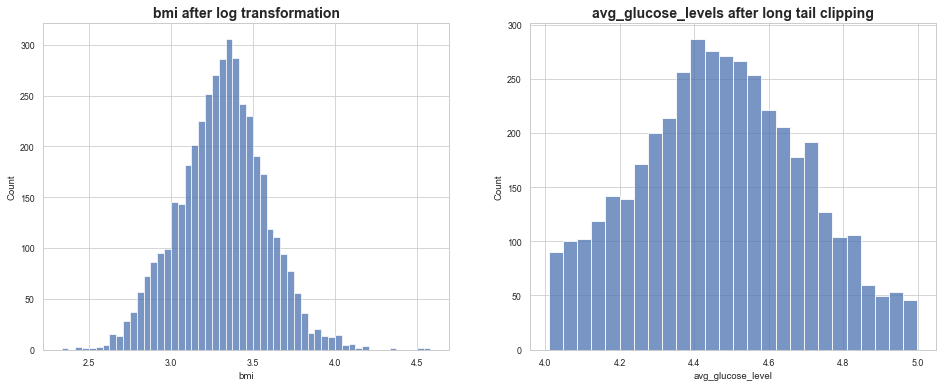

<Figure size 432x288 with 0 Axes>

In [363]:
# (F) Univariate data analysis

# Plotting a histogram of bmi and avg_glucose_level 

plt.figure(figsize = [16, 6])

plt.subplot(1, 2, 1)
ax = sns.histplot(data = stroke, x='bmi')
plt.title('bmi', fontsize = 14, fontweight="bold")

# Interpretation: The histogram has quite some distance between the largest and smallest observations. Looking back at the st. dev we see size of 78.28. Largest of all parks.
# This could indicate that the park hosts many different species (mammals, plants etc.) This could also indicate outliers of species not present in other parks. 

plt.subplot(1, 2, 2)

ax1 = sns.histplot(data = stroke, x='avg_glucose_level')
plt.title('avg_glucose_levels', fontsize = 14, fontweight="bold")
plt.show()
plt.clf()

# Interpretation: The bmi and glucose variable is right-skewed. We do not have normal distributions in either of the graphs. This is important to note, and could be due to sampling issues
# This indicates that there are outliers. 


# Fixing this with Numpys log-transformation

stroke[['bmi', 'avg_glucose_level']] = np.log(stroke[['bmi', 'avg_glucose_level']])

plt.figure(figsize = [16, 6])

plt.subplot(1, 2, 1)
ax = sns.histplot(data = stroke, x='bmi')
plt.title('bmi after log transformation', fontsize = 14, fontweight="bold")

plt.subplot(1, 2, 2)

ax1 = sns.histplot(data = stroke, x='avg_glucose_level')
plt.title('avg_glucose_levels after log transformation', fontsize = 14, fontweight="bold")
plt.show()
plt.clf()

# The bmi variable looks good, meanwhile the avg_glucose_levels could use some different transformation to remedy the bimodal peaks
# The long tail is clearly not indicative of a gaussian representation. A simple drop function will remove the tail.

stroke.drop(stroke[stroke['avg_glucose_level'] >= 5.0].index, inplace = True)

# Checking the graphs again

plt.figure(figsize = [16, 6])

plt.subplot(1, 2, 1)
ax = sns.histplot(data = stroke, x='bmi')
plt.title('bmi after log transformation', fontsize = 14, fontweight="bold")

plt.subplot(1, 2, 2)

ax1 = sns.histplot(data = stroke, x='avg_glucose_level')
plt.title('avg_glucose_levels after long tail clipping', fontsize = 14, fontweight="bold")
plt.show()
plt.clf()

# The variables bmi and avg_glucose_levels look really good

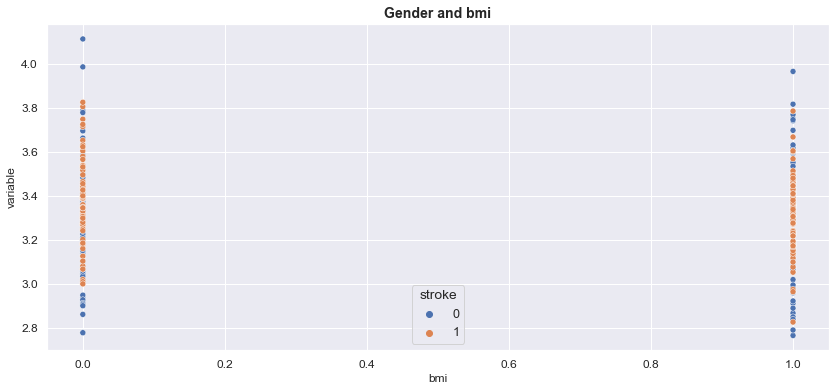

<Figure size 432x288 with 0 Axes>

In [368]:
# (F) Bivariate data analysis

# Plotting a violinplot of gender and bmi

plt.figure(figsize=(14,6))
sns.scatterplot(data = stroke, x = 'residence_type', y = 'bmi', hue='stroke')

plt.title('Gender and bmi', fontsize= 14, fontweight="bold")

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.xlabel('bmi', fontsize = 12)
plt.ylabel('variable', fontsize = 12)


plt.show()
plt.clf()

# Interpretation: The violin plots reveals two important things. One, it asserts that the other category in gender is heavenly underrepresented
# The values should be extracted from the dataset as they provide more noise than usage
# Secondly, the violin plots depict how bmi between the genders look quite similar. The male median is although a slight bit higher. 
# Meanwhile the females have the lowest bmi value while males have the highest.

stroke.drop(stroke[stroke['gender'] == 2].index, inplace = True)


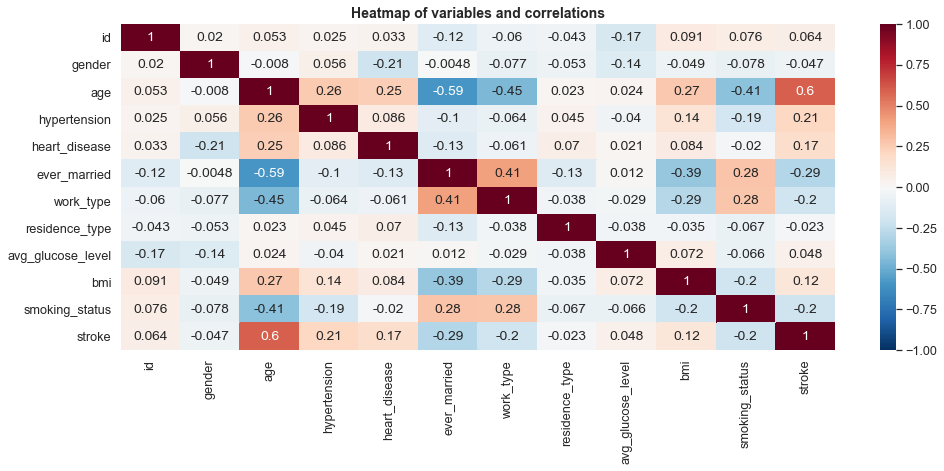

<Figure size 432x288 with 0 Axes>

In [370]:
# (F) Multivariate analysis

sns.set(font_scale=1.15)
plt.figure(figsize = [16, 6])

sns.heatmap(
    stroke.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

plt.title('Heatmap of variables and correlations', fontsize= 14, fontweight="bold")
plt.show()
plt.clf()

# Interpretation: The 

4. Supervised classification 

Q1 What model is best at predicting strokes?

In [366]:
# Q1: 

# Starting by counting the number of instances with stroke

print(stroke.groupby('stroke').count())

# We see a total of 4229 instances, where 132 are active strokes. To avoid overrepresenting the instances that do not contain strokes 
# The table must drop some of the 0 instances.

def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

stroke = downsample(stroke, 'stroke')

print(stroke.groupby('stroke').count())

# To test models we need to split the data into training and test data. Since the dataset has a high amount of samples, the split can include
# a high number of training data

# Split the data into variables and the classifiction attribute

collist = (['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'])

stroke_x = stroke[collist]

stroke_y = stroke['stroke']

X_train, X_test, y_train, y_test = train_test_split(stroke_x,stroke_y, test_size=0.33, random_state=1)

# Create parameters for the models

log_reg_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
dec_tree_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
rand_for_params = [{"criterion": "gini"}, {"criterion": "entropy"}]
kneighbors_params = [{"n_neighbors":3}, {"n_neighbors":5}]
naive_bayes_params = [{}]
svc_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]

# Create models

modelclasses = [
    ["log regression", LogisticRegression, log_reg_params],
    ["decision tree", DecisionTreeClassifier, dec_tree_params],
    ["random forest", RandomForestClassifier, rand_for_params],
    ["k neighbors", KNeighborsClassifier, kneighbors_params],
    ["naive bayes", GaussianNB, naive_bayes_params],
    ["support vector machines", SVC, svc_params]
]

# Testing the models

insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        insights.append((modelname, model, params, score))
        

insights.sort(key=lambda x:x[-1], reverse=True)
for modelname, model, params, score in insights:
    print(modelname, params, score)


          id  gender   age  hypertension  heart_disease  ever_married  \
stroke                                                                  
0       4097    4097  4097          4097           4097          4097   
1        132     132   132           132            132           132   

        work_type  residence_type  avg_glucose_level   bmi  smoking_status  
stroke                                                                      
0            4097            4097               4097  4097            4097  
1             132             132                132   132             132  
         id  gender  age  hypertension  heart_disease  ever_married  \
stroke                                                                
0       132     132  132           132            132           132   
1       132     132  132           132            132           132   

        work_type  residence_type  avg_glucose_level  bmi  smoking_status  
stroke                                

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

log regression {'C': 1} 0.7954545454545454
log regression {'C': 10} 0.7954545454545454
support vector machines {'C': 0.1} 0.7954545454545454
random forest {'criterion': 'gini'} 0.7840909090909091
log regression {'C': 0.01} 0.7727272727272727
decision tree {'criterion': 'entropy'} 0.7727272727272727
naive bayes {} 0.7727272727272727
support vector machines {'C': 1} 0.7727272727272727
support vector machines {'C': 10} 0.7727272727272727
log regression {'C': 0.1} 0.7613636363636364
decision tree {'criterion': 'gini'} 0.7613636363636364
random forest {'criterion': 'entropy'} 0.7613636363636364
k neighbors {'n_neighbors': 3} 0.7613636363636364
k neighbors {'n_neighbors': 5} 0.75
support vector machines {'C': 0.01} 0.45454545454545453


In [367]:
# The results showcase that logistic regression, random forest, and support vector machines models 
# all perform well with an accuracy of 0.77 to 0.79

# Moreover the multivariate analysis showcased the variables age, hypertension and heart_disease as the most significant contributions 
# To having a stroke

5. Conclusion

The analysis has showcased how data can be used to predict and understand strokes. Strokes seems to be less observed, while age is low and no heart diseases nor hypertensions are present. Meanwhile variables such as married status and residence type have less effect on having a stroke.

Further investigations should aim to couple the data with other medical dimensions to further strengthen the stroke hypothesis. For example, to find which heart diseases have the greatest effect on strokes. Moreover, in a data engineering sense, one could aim to remove the less contributing variables from the model and thus increase their potency. It is worthwhile to mention that the scores were modeled on a 50/50 split for the stroke variable. In other words the models assumed 50 percent of the population have a stroke. This is not representative of real population.